In [ ]:
import locale
locale.getpreferredencoding = lambda *args, **kwargs: "UTF-8"
!pip install transformers==4.28.0
!pip install --upgrade accelerate
!pip install jellyfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
import csv
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = ''.join([c for c in text if c.isalpha() or c.isspace()]).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and perform stemming
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
import csv
import matplotlib.pyplot as plt
import random
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Read data from CSV file
data = []
with open('train_data_final.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        question = preprocess_text(row[0])
        answer = preprocess_text(row[1])
        data.append((question, answer))

# Shuffle the indices
indices = list(range(len(data)))
random.shuffle(indices)

# Shuffle the dataset while preserving the correspondence between questions and answers
shuffled_data = [data[i] for i in indices]

# Prepare the training dataset
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='train_data_final.csv',
    block_size=128  # Adjust the block size as per your data
)


# Define your training arguments as before
training_args = TrainingArguments(
    output_dir='./output',
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    learning_rate=2e-5,
    weight_decay=0.02,
    warmup_steps=500,
    logging_dir='./logs'
)

# Initialize your Trainer as before
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
    train_dataset=train_dataset
)


# Initialize lists to store training loss and learning rate
train_loss_list = []
learning_rate_list = []

# Override the compute_loss method to track training loss and learning rate
def compute_loss(model, inputs, return_outputs=False):
    outputs = model(**inputs)
    loss = outputs.loss
    train_loss_list.append(loss.item())
    learning_rate_list.append(trainer.optimizer.param_groups[0]['lr'])  # Get current learning rate from optimizer
    return (loss, outputs) if return_outputs else loss

# Patch the Trainer to use the custom compute_loss method
trainer.compute_loss = compute_loss

# Start the fine-tuning
trainer.train()

# Save the fine-tuned model
trainer.save_model("./output_model")

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.775700
1000,2.257100
1500,2.107700
2000,2.023400
2500,1.946900
3000,1.888800
3500,1.839400
4000,1.800600
4500,1.752600
5000,1.726600


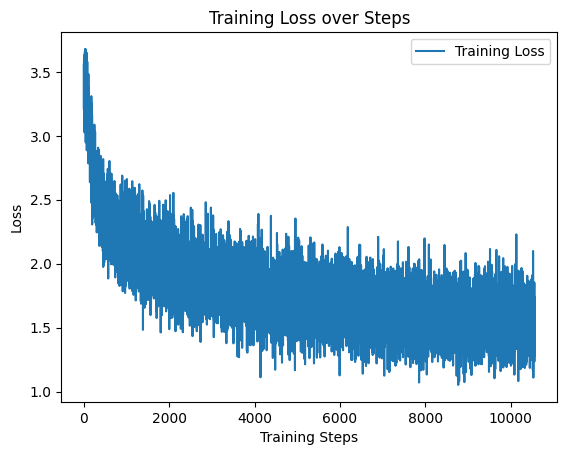

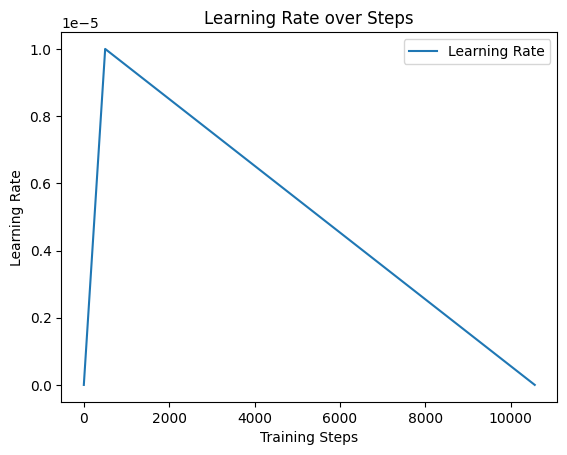

In [ ]:
# Plot learning rate
plt.plot(range(len(learning_rate_list)), learning_rate_list, label='Learning Rate')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.legend()
plt.show()

In [ ]:
greetings = {
    "hi": "Hello!",
    "hello": "Hi there!",
    "hey": "Hey, how can I assist you?",
    "greetings": "Greetings! How may I help you?",
    "how are you": "I'm good, thank you! How about you?",
    "what's up": "Not much, just here to assist you!",
    "good morning": "Good morning! How can I assist you today?",
    "good afternoon": "Good afternoon! How may I help you?",
    "good evening": "Good evening! How can I assist you today?",
    "howdy": "Howdy! What can I do for you?",
    "nice to meet you": "Nice to meet you too!",
    "what's going on": "Just here to help. How can I assist you?",
    "hey there": "Hello! How can I assist you today?",
    "long time no see": "Yes, it has been a while! How may I assist you?",
    "what can you do": "I can answer your questions and assist with information. How can I help you?",
    "it's nice to see you": "Thank you! How can I assist you today?",
    "what's happening": "Not much, just here to assist you!",
    "how's it going": "I'm doing well. How can I assist you?",
    "good to see you": "Good to see you too! How may I assist you?",
    "hey buddy": "Hey! What can I do for you today?",
    "how have you been": "I've been good. How about you?",
    "good to meet you": "Likewise! How can I assist you?",
    "what's new": "Not much, just here to assist you!",
    "hey stranger": "Hello! How can I assist you today?",
    "how's everything": "Everything is going well. How may I help you?",
    "nice to see you": "Nice to see you too! How can I assist you today?",
    "hey mate": "Hey! What can I do for you today?",
    "how's your day": "My day is going well. How can I assist you?",
    "pleased to meet you": "Pleased to meet you too! How can I assist you?",
    "what's the latest": "Not much, just here to assist you!",
    "hey friend": "Hello! How can I assist you today?",
    "how's life": "Life is good. How may I assist you?",
    "what's going on buddy": "Not much, just here to assist you!",
    "hiya": "Hi there! How can I help you today?",
    "how are things": "Things are going well. How can I assist you?",
    "what's happening mate": "Not much, just here to assist you!",
    "hey pal": "Hey! What can I do for you today?",
    "how's your day going": "My day is going well. How can I assist you?",
    "good to see you again": "Good to see you too! How may I assist you?",
    "what's new buddy": "Not much, just here to assist you!",
    "hey there friend": "Hello! How can I assist you today?",
    "how's your day been": "My day has been good. How can I assist you?",
    "nice to meet you too": "Nice to meet you too! How can I assist you today?",
    "hey dude": "Hey! What can I do for you today?",
    "how's everything going": "Everything is going well. How can I assist you?",
    "what's happening friend": "Not much, just here to assist you!",
    "hey amigo": "Hey! What can I do for you today?",
    "how's your day so far": "My day is going well. How can I assist you?",
    "good to see you once again": "Good to see you too! How may I assist you?",
    "what's new pal": "Not much, just here to assist you!",
    "hey there mate": "Hello! How can I assist you today?",
    "how's your day treating you": "My day is treating me well. How can I assist you?",
    "nice to meet you once more": "Nice to meet you too! How can I assist you today?",
    "thank you": "You're welcome!",
    "thanks": "You're welcome!",
    "goodbye": "Goodbye!",
    "bye": "Goodbye!",
    "sorry": "No problem, I understand!",
    "help": "Of course! What do you need help with?",
    "yes": "Yes, I can help you with that!",
    "no": "Alright, let me know if you need any assistance!",
    "tell me a joke": "sure, here's a joke: Why don't scientists trust atoms? Because they make up everything!",
    "great": "That's fantastic!",
    "awesome": "That's great to hear!",
    "good to know": "I'm glad you found that helpful!",
    "you're amazing": "Thank you! I'm here to assist you!",
    "you're the best": "Thank you! I'm here to help!",
    "can you help me": "Absolutely! What do you need assistance with?",
    "you're funny": "I try my best to bring a smile!",
    "you're cool": "Thank you! I'm here to assist you!",
    "you're awesome": "Thank you! I'm here to help!",
    "that's cool": "I'm glad you think so!",
    "that's interesting": "I find that fascinating too!",
    "well done": "Thank you! I aim to provide helpful responses!",
    "you're clever": "Thank you! I'm here to assist you!",
    "good job": "Thank you! I'm here to help!",
    "that's helpful": "I'm glad I could be of assistance!",
    "you're smart": "Thank you! I'm here to assist you!",
    "you're knowledgeable": "Thank you! I'm here to help!",
    "you're reliable": "Thank you! I'm here to assist you!",
    "you're dependable": "Thank you! I'm here to help!",
    "that's nice": "I'm glad you think so!",
    "you're great": "Thank you! I'm here to assist you!",
    "you're wonderful": "Thank you! I'm here to help!",
    "that's impressive": "I'm glad you find it impressive!",
    "you're resourceful": "Thank you! I'm here to assist you!",
    "you're helpful": "Thank you! I'm here to help!",
    "you're supportive": "Thank you! I'm here to assist you!",
    "you're encouraging": "Thank you! I'm here to help!",
    "that's awesome": "I'm glad you think so!",
    "you're fantastic": "Thank you! I'm here to assist you!",
    "that's great": "I'm glad you find it great!",
    "you're incredible": "Thank you! I'm here to assist you!",
    "you're outstanding": "Thank you! I'm here to help!",
    "that's wonderful": "I'm glad you think so!",
    "you're remarkable": "Thank you! I'm here to assist you!",
    "you're impressive": "Thank you! I'm here to help!",
    "that's excellent": "I'm glad you find it excellent!",
    "you're extraordinary": "Thank you! I'm here to assist you!",
    "you're exceptional": "Thank you! I'm here to help!",
    "that's remarkable": "I'm glad you think so!",
    "that's fantastic": "I'm glad you find it fantastic!",
    "that's brilliant": "I'm glad you think so!",
    "you're the greatest": "Thank you! I'm here to assist you!",
    "you're the coolest": "Thank you! I'm here to assist you!",
    "you're the most helpful": "Thank you! I'm here to help!",
    "that's amazing": "I'm glad you think so!",
    "you're the most knowledgeable": "Thank you! I'm here to assist you!",
    "you're the most reliable": "Thank you! I'm here to help!",
    "you're the most dependable": "Thank you! I'm here to assist you!",
    "you're the smartest": "Thank you! I'm here to help!",
    "you're the most clever": "Thank you! I'm here to assist you!",
    "you're the most resourceful": "Thank you! I'm here to help!",
    "you're the most supportive": "Thank you! I'm here to assist you!",
    "you're the most encouraging": "Thank you! I'm here to help!",
    "you're the most fantastic": "Thank you! I'm here to assist you!",
    "you're the most incredible": "Thank you! I'm here to help!",
    "you're the most wonderful": "Thank you! I'm here to assist you!",
    "nevermind": "I'm glad I could be of assistance!"
    }

In [ ]:
import logging
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Disable transformers' logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained('./output_model')  # Path to the fine-tuned model's directory
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token_id to the end of sentence token (eos_token_id)

# Set the model to evaluate mode
model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate model responses
def generate_response(prompt):
    prompt = prompt.lower()

    # Check if prompt matches a greeting
    for greeting in greetings:
        if greeting == prompt:
            return greetings[greeting]

    # Check if the prompt is empty or contains only one word
    if len(prompt.strip().split()) <= 1:
        return "I'm sorry, I couldn't generate a response. Kindly rephrase your query so I am able to understand better."

    input_ids = tokenizer.encode(prompt, return_tensors='pt', padding=True)

    # Move the input tensor to the same device as the model
    input_ids = input_ids.to(device)

    attention_mask = input_ids.ne(tokenizer.pad_token_id)
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=150, num_return_sequences=1)

    responses = []
    for generated in output:
        response = tokenizer.decode(generated, skip_special_tokens=True)
        responses.append(response)

    try:
        if len(responses) > 0:
            lines = responses[0].split('\n')
            lines2 = lines[0].split(',"')
            answer_line = lines2[1].replace('"', "")
            return answer_line
    except IndexError:
        pass

    return "I'm sorry, I couldn't generate a response. Kindly rephrase your query so I am able to understand better."


In [ ]:
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import jellyfish

def jaccard_similarity(question, answer):
    set_question = set(question.lower().split())
    set_answer = set(answer.lower().split())
    intersection = len(set_question.intersection(set_answer))
    union = len(set_question) + len(set_answer) - intersection
    similarity = intersection / union
    return similarity

# Read test dataset
test_data = []
with open('test_data_final.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_data.append(row)

# Skip the first row containing column headers
test_data = test_data[1:]

# Prepare test dataset
test_questions = []
test_answers = []

for row in test_data:
    test_questions.append(row[0])
    test_answers.append(row[1])

# Generate responses
generated_answers = []
for question in test_questions:
    generated_answers.append(generate_response(question))

print("Total number of records:", len(test_questions))

# Calculate similarity metrics
cosine_similarities = []
jaccard_similarities = []
levenshtein_distances = []

for i in range(len(test_answers)):
    answer = test_answers[i]
    generated_answer = generated_answers[i]

    # Calculate cosine similarity
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([answer, generated_answer])
    cosine_similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    cosine_similarities.append(cosine_similarity_score)

    # Calculate Jaccard similarity
    jaccard_similarity_score = jaccard_similarity(answer, generated_answer)
    jaccard_similarities.append(jaccard_similarity_score)

# Calculate accuracy based on similarity thresholds
cosine_threshold = 0.5
jaccard_threshold = 0.5

cosine_matches = sum(score >= cosine_threshold for score in cosine_similarities)
jaccard_matches = sum(score >= jaccard_threshold for score in jaccard_similarities)

accuracy_cosine = cosine_matches / len(test_data)
accuracy_jaccard = jaccard_matches / len(test_data)

# Print the evaluation scores
print(f"Cosine Similarity: {accuracy_cosine:.4f}")
print(f"Jaccard Similarity: {accuracy_jaccard:.4f}")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


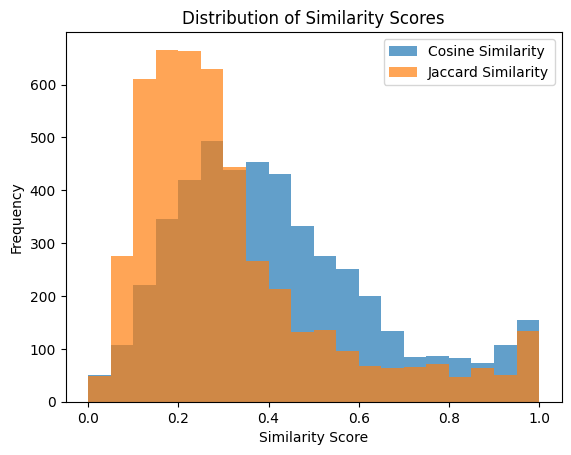

In [ ]:
# Plot similarity scores
plt.hist(cosine_similarities, bins=20, alpha=0.7, label='Cosine Similarity')
plt.hist(jaccard_similarities, bins=20, alpha=0.7, label='Jaccard Similarity')

plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.show()

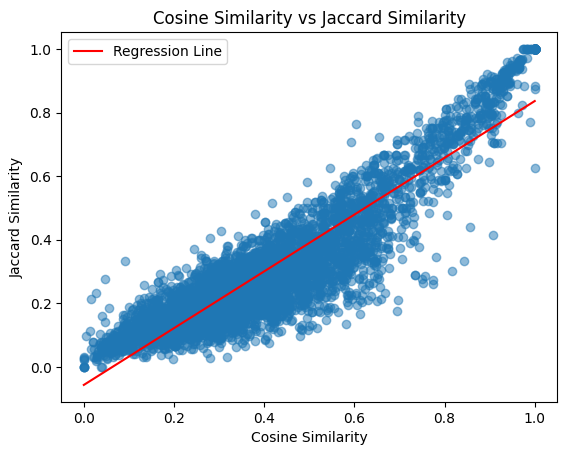

In [ ]:
import numpy as np

# Create a scatter plot
plt.scatter(cosine_similarities, jaccard_similarities, alpha=0.5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Jaccard Similarity')
plt.title('Cosine Similarity vs Jaccard Similarity')

# Add a regression line
coefficients = np.polyfit(cosine_similarities, jaccard_similarities, 1)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(0, 1, 100)
plt.plot(x_values, polynomial(x_values), color='red', label='Regression Line')

plt.legend()
plt.show()

In [ ]:
# Create a dataframe
df = pd.DataFrame({'Question': test_questions,
                   'Predicted Answer': generated_answers,
                   'True Answer': test_answers})

# Save the output to CSV for analysis
df.to_csv('output.csv', index=False)

In [ ]:
# Chatbot loop
while True:
    user_input = input('User: ')
    if user_input == "Bye":
        print('Chatbot: Goodbye')
        break
    else:
        response = generate_response(user_input)
        print('Chatbot:', response)

#What's the legal age of getting a G1 and G2 driver's license in Ontario?
#I want answers to some traffic questions.